In [1]:
%%capture
from datetime import datetime
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import display
from sklearn import metrics
plt.rcParams.update({"font.size": 12})
%matplotlib inline

In [2]:
wsb_users_data = pd.read_csv("data/WSB_data_with_emb.csv",sep=';', usecols = ['title','selftext'], low_memory = True)
stocks_users_data= pd.read_csv("stocks/data/stocks_submissions_all.csv",sep=';', usecols = ['title','selftext'], low_memory = True)
investing_users_data= pd.read_csv("investing/data/investing_submissions_all.csv",sep=';', usecols = ['title','selftext'], low_memory = True)

In [3]:
# Create new column denoting class label and combine into one df
wsb_users_data['sub'] = 'wsb'
stocks_users_data['sub'] = 'stocks'
investing_users_data['sub'] = 'investing'

In [4]:
wsb_common_users_data = wsb_users_data[['title','selftext','sub']]

In [5]:
stocks_common_users_data = stocks_users_data[['title','selftext','sub']]

In [6]:
investing_common_users_data = investing_users_data[['title','selftext','sub']]

In [7]:
investing_common_users_data.head(1)

,title,selftext,sub
0,What do you use to invest?,[removed],investing


In [8]:
all_data = wsb_common_users_data.append(investing_common_users_data, ignore_index=True)

In [9]:
all_data = all_data.append(stocks_common_users_data, ignore_index=True)

In [10]:
all_data = all_data[pd.notnull(all_data['selftext'])]

In [11]:
all_data = all_data[pd.notnull(all_data['title'])]

In [12]:
all_data.head(1)

,title,selftext,sub
0,BB,So 13.56 cad for BB. It’s moving and gaining ...,wsb


In [13]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478617 entries, 0 to 1144021
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   title     478617 non-null  object
 1   selftext  478617 non-null  object
 2   sub       478617 non-null  object
dtypes: object(3)
memory usage: 14.6+ MB


In [14]:
all_data['sub_id'] = all_data['sub'].factorize()[0]
category_id_df = all_data[['sub', 'sub_id']].drop_duplicates().sort_values('sub_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['sub_id', 'sub']].values)
all_data.head()

,title,selftext,sub,sub_id
0,BB,So 13.56 cad for BB. It’s moving and gaining ...,wsb,0
4,BB,"BB is on the move higher, not because of the p...",wsb,0
9,Don't Be A Menace To Hedge Funds By Squeezing ...,"What up, nerds? Long time no post. I come bear...",wsb,0
10,$372k gains from TSLA deliveries and pre-earnings,TSLA has been beating estimates for deliveries...,wsb,0
14,Serious question: Trying to understand why AMC...,Why keep buying AMC when it's -6 billion and 2...,wsb,0


In [15]:
sample_data=all_data.sample(frac = 0.1)

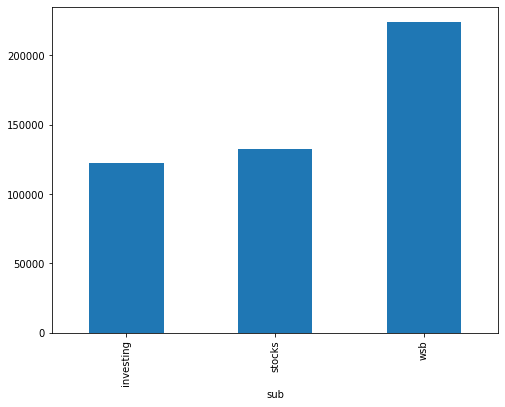

In [16]:
fig = plt.figure(figsize=(8,6))
all_data.groupby('sub').title.count().plot.bar(ylim=0)
plt.show()

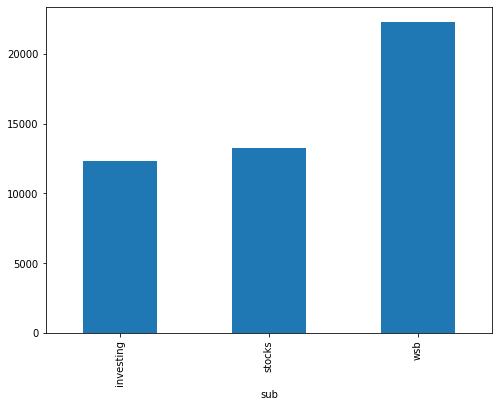

In [17]:
fig = plt.figure(figsize=(8,6))
sample_data.groupby('sub').title.count().plot.bar(ylim=0)
plt.show()

In [18]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 1), stop_words='english')
features = tfidf.fit_transform(sample_data.title).toarray() #+all_data.selftext
labels = sample_data.sub_id
features.shape

(47862, 5391)

In [19]:
N = 10
for Product, category_id in sorted(category_to_id.items()):
   # X{array-like, sparse matrix} of shape (n_samples, n_features)
    #y -array-like of shape (n_samples,)
    #Target vector (class labels).
  features_chi2 = chi2(features, labels == category_id) 

  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
 
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))


# 'investing':
  . Most correlated unigrams:
. moon
. roth
. funds
. index
. ira
. invest
. amc
. gme
. investment
. investing
# 'stocks':
  . Most correlated unigrams:
. nok
. yolo
. wsb
. moon
. bb
. amc
. gme
. thoughts
. stock
. stocks
# 'wsb':
  . Most correlated unigrams:
. stock
. yolo
. invest
. nok
. bb
. moon
. stocks
. investing
. amc
. gme


In [20]:
X_train, X_test, y_train, y_test = train_test_split(sample_data['title'], sample_data['sub'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [21]:
print(clf.predict(count_vect.transform(["🦍"])))

['wsb']


In [22]:
print(clf.predict(count_vect.transform(["🚀"])))

['wsb']


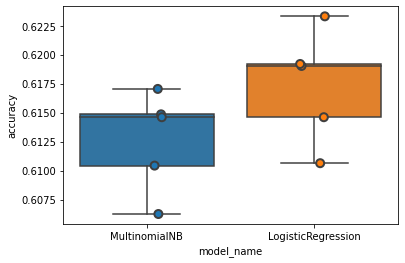

In [23]:
models = [
   
    MultinomialNB(),
    LogisticRegression(random_state=0,max_iter=3000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [24]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression    0.617358
MultinomialNB         0.612636
Name: accuracy, dtype: float64

In [25]:
category_id_df['sub'].values

array(['wsb', 'investing', 'stocks'], dtype=object)

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


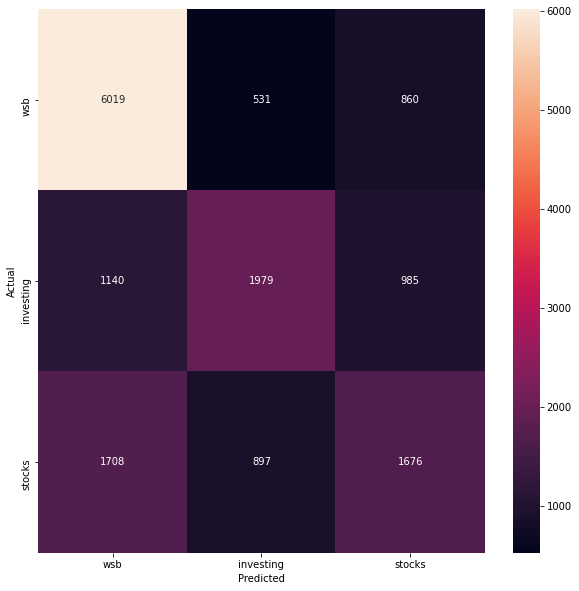

In [26]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, sample_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['sub'].values, yticklabels=category_id_df['sub'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
category_id_df

,sub,sub_id
0,wsb,0
861752,investing,1
989521,stocks,2


In [28]:
from IPython.display import display
for predicted in category_id_df.sub_id:
  for actual in category_id_df.sub_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(sample_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['sub', 'title']])
      print('')

'investing' predicted as 'wsb' : 1140 examples.


,sub,title
929171,investing,I accidentally did a wash sale
909959,investing,Cash on hand
949517,investing,Options Expiring
863037,investing,Do you guys think Elon Musk wants to retire fr...
916681,investing,MBA OR CFA?
...,...,...
908865,investing,NOK NOK is about to surge hop on the train guy...
952861,investing,Options strike price by expiry date
966261,investing,Is the CFA a necessity?
869754,investing,Is SNDL(Sundial) a losing fight?



'stocks' predicted as 'wsb' : 1708 examples.


,sub,title
1113946,stocks,Spirit Airlines SAVE
1102381,stocks,No more gambling
1048570,stocks,SINO - Buy Opportunity?
1073214,stocks,Teladoc (TDOC) is up 11-12% today
1012750,stocks,Trading induced stress tips
...,...,...
1103619,stocks,TT
995808,stocks,Lucid Motors
1040844,stocks,crypt and infl.
1008006,stocks,CLF: Sell the news on infrastructure deal or h...



'wsb' predicted as 'investing' : 531 examples.


,sub,title
751247,wsb,COVID Vaccine Stocks Long Call or Put? The mum...
775568,wsb,🌈🐻 vs the 🌈FED
601263,wsb,When morons ask stupids questions
778999,wsb,S&amp;P Futures money 💰
200776,wsb,These 6 Flags stocks bout to make the next gen...
...,...,...
815419,wsb,"What if, Salesforce (CRM) did in fact make tha..."
830212,wsb,Stock vs Forex vs Comodity Market
155650,wsb,Impact Investing - Free Money through Robinhoo...
144602,wsb,Kinross Gold



'stocks' predicted as 'investing' : 897 examples.


,sub,title
1074680,stocks,Novice Investing Strategy from Jan 2020. Movin...
1100508,stocks,I think my cfp just violated our contract
994046,stocks,Where does Elon Musk have his shares ?
1005074,stocks,Avoiding a Taper Tantrum; The Federal Reserve’...
1023185,stocks,Are there any super-junk bonds/debt securities...
...,...,...
1027105,stocks,Any benefits to Traders Tax Status?
1093441,stocks,Share your Finviz Filters your using as a Long...
993826,stocks,I bought some ETFs. What should I do if my bro...
999206,stocks,Where to Invest after next US rate hike?



'wsb' predicted as 'stocks' : 860 examples.


,sub,title
843556,wsb,How do you guys find penny stocks?
58916,wsb,Sell your AMC stock now
179649,wsb,RGBP - need some help here
459267,wsb,Best trading app for the UK? (newcomer)
771529,wsb,Gushing Losses -92.87%
...,...,...
290560,wsb,New investor
627152,wsb,Webull Stock Lending Income Program
589381,wsb,Get into SPCE stock right now.
722553,wsb,Good places to start out / learn for beginners?



'investing' predicted as 'stocks' : 985 examples.


,sub,title
984226,investing,RBC buying stocks on OTC when requested to be ...
936610,investing,[Hypothetical] let's assume you thought there ...
882027,investing,What happens with a company' stocks after it h...
887064,investing,10 Bagger and 100 Bagger Investments
930672,investing,"AAPL, TSLA Stock Split and Options Trading"
...,...,...
953523,investing,Anyone else listening to this press conference?
890650,investing,Hi I have a question about going all in on cer...
892984,investing,What Do You Think of GSAT? Is this Stock worth...
900586,investing,Very confused. Need help regarding after marke...


In [29]:
model.fit(features, labels)

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [30]:
N = 25
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  trigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 3][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))
  print("  . Top trigrams:\n       . {}".format('\n       . '.join(trigrams)))

# 'investing':
  . Top unigrams:
       . spitballin
       . investing
       . bonds
       . bitcoin
       . investment
       . 401k
       . investments
       . crypto
       . retirement
       . vanguard
       . bond
       . returns
       . basic
       . asset
       . ira
       . tariffs
       . etfs
       . invest
       . tencent
       . registration
       . private
       . economic
       . investors
       . etf
       . advisor
  . Top bigrams:
       . 
  . Top trigrams:
       . 
# 'stocks':
  . Top unigrams:
       . stocks
       . dgly
       . se
       . recap
       . stock
       . affected
       . enph
       . evergrande
       . rtx
       . gnus
       . appl
       . ark
       . penn
       . watchlists
       . gush
       . petroleum
       . nat
       . limited
       . scalping
       . australis
       . sls
       . yard
       . xpeng
       . srne
       . fmci
  . Top bigrams:
       . 
  . Top trigrams:
       . 
# 'wsb':
  . Top unig

In [31]:
print(metrics.classification_report(y_test, y_pred, target_names=sample_data['sub'].unique()))

              precision    recall  f1-score   support

         wsb       0.68      0.81      0.74      7410
   investing       0.58      0.48      0.53      4104
      stocks       0.48      0.39      0.43      4281

    accuracy                           0.61     15795
   macro avg       0.58      0.56      0.57     15795
weighted avg       0.60      0.61      0.60     15795



# 'investing':
Feature: , Score:  (0, ('gme', -2.1971975765539944))
Feature: , Score:  (1, ('amc', -1.9322071092543611))
Feature: , Score:  (2, ('tendies', -1.9205117216868917))
Feature: , Score:  (3, ('yolo', -1.8660127598099212))
Feature: , Score:  (4, ('retards', -1.7544373690872994))
Feature: , Score:  (5, ('clov', -1.7455687559445845))
Feature: , Score:  (6, ('moon', -1.6072013627919064))
Feature: , Score:  (7, ('apes', -1.5542158443378133))
Feature: , Score:  (8, ('nokia', -1.5471018451417067))
Feature: , Score:  (9, ('bynd', -1.4814893680804417))
Feature: , Score:  (10, ('restrictions', -1.447182234777994))
Feature: , Score:  (11, ('ape', -1.4017179989667699))
Feature: , Score:  (12, ('retard', -1.3945298706047584))
Feature: , Score:  (13, ('retarded', -1.3674715553773966))
Feature: , Score:  (14, ('literally', -1.3585041492795287))
Feature: , Score:  (15, ('nio', -1.3466806477580837))
Feature: , Score:  (16, ('stonks', -1.3466483956187232))
Feature: , Score:  (17, ('uwmc', -1.3

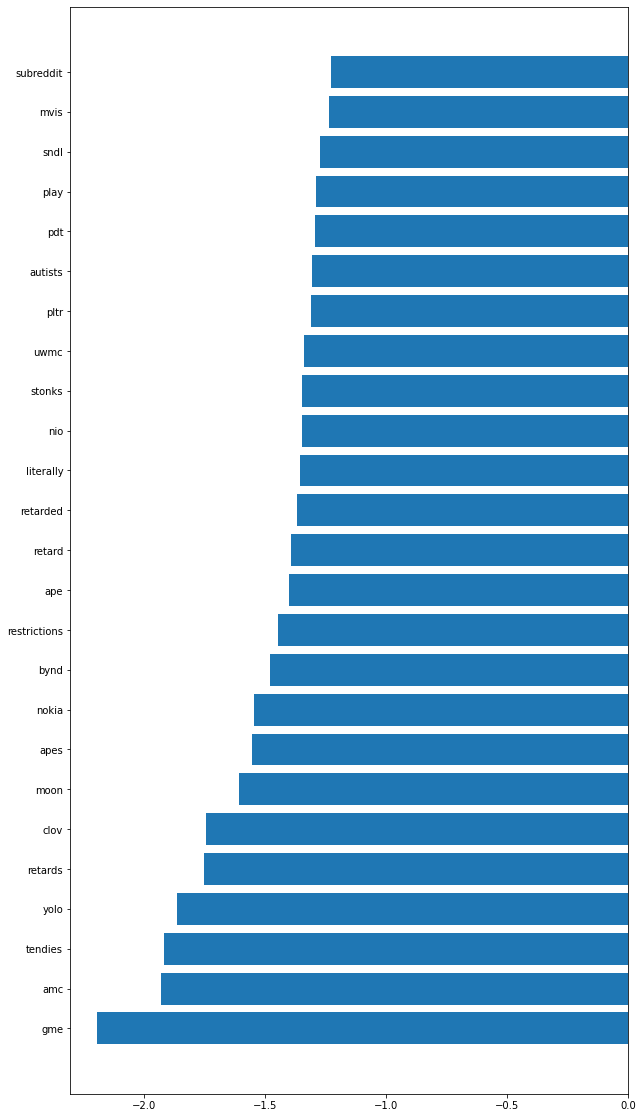

# 'stocks':
Feature: , Score:  (0, ('2019', -2.137103382549614))
Feature: , Score:  (1, ('thread', -1.9730162164095153))
Feature: , Score:  (2, ('retards', -1.740572831198632))
Feature: , Score:  (3, ('retard', -1.5776265109193945))
Feature: , Score:  (4, ('autist', -1.5442003798999675))
Feature: , Score:  (5, ('autists', -1.5215177397008715))
Feature: , Score:  (6, ('wsb', -1.5025229191250558))
Feature: , Score:  (7, ('retarded', -1.466479179468175))
Feature: , Score:  (8, ('bears', -1.4578879317942888))
Feature: , Score:  (9, ('basic', -1.4306289907447516))
Feature: , Score:  (10, ('autistic', -1.3031216106346049))
Feature: , Score:  (11, ('period', -1.2746280885962908))
Feature: , Score:  (12, ('yolo', -1.2689502883762709))
Feature: , Score:  (13, ('fucking', -1.2564917051194011))
Feature: , Score:  (14, ('porn', -1.2435199746929462))
Feature: , Score:  (15, ('fuck', -1.2363120366427727))
Feature: , Score:  (16, ('ibkr', -1.2293967203917673))
Feature: , Score:  (17, ('lower', -1.215

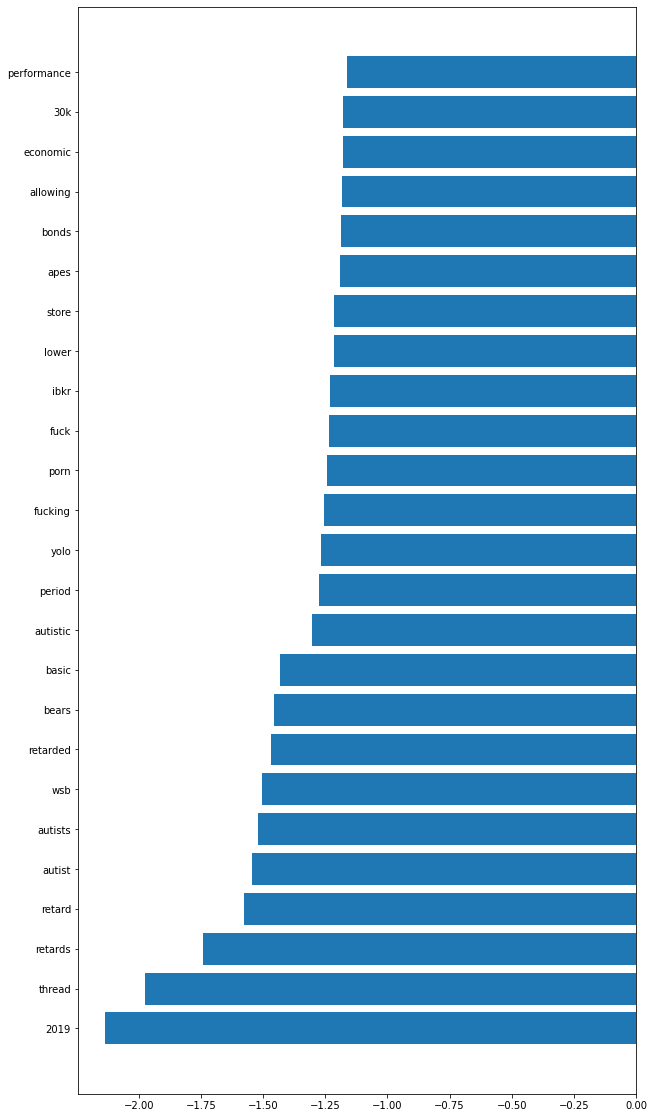

# 'wsb':
Feature: , Score:  (0, ('investing', -2.692757401181552))
Feature: , Score:  (1, ('bitcoin', -2.5975819383597645))
Feature: , Score:  (2, ('etfs', -2.5142115678701))
Feature: , Score:  (3, ('etf', -2.4288406498653328))
Feature: , Score:  (4, ('investment', -2.2329801146666957))
Feature: , Score:  (5, ('portfolio', -2.2043419941088986))
Feature: , Score:  (6, ('crypto', -2.2009235346657365))
Feature: , Score:  (7, ('stocks', -2.185150731784911))
Feature: , Score:  (8, ('roth', -2.0760861418680556))
Feature: , Score:  (9, ('investments', -2.0418312017162252))
Feature: , Score:  (10, ('https', -2.0262224845282066))
Feature: , Score:  (11, ('invest', -2.01537226533745))
Feature: , Score:  (12, ('questions', -1.9817240753571104))
Feature: , Score:  (13, ('spitballin', -1.8844051988065007))
Feature: , Score:  (14, ('ira', -1.7792881802749354))
Feature: , Score:  (15, ('index', -1.7361159638327182))
Feature: , Score:  (16, ('voo', -1.7326636535164548))
Feature: , Score:  (17, ('vti',

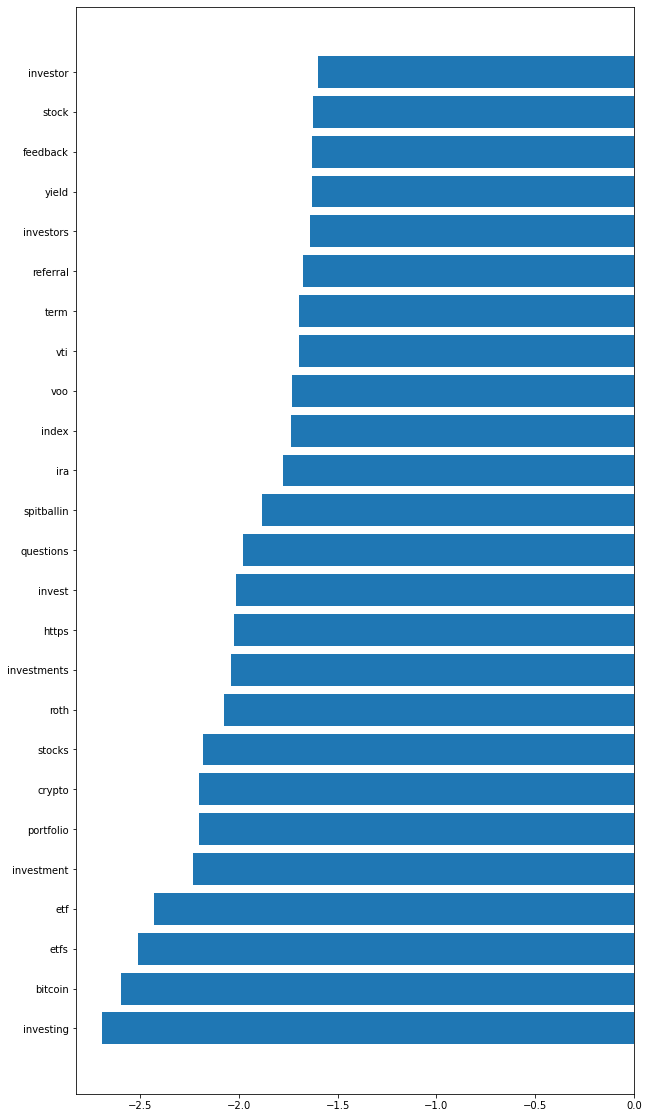

In [32]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[:25],importance[:25])):
        print('Feature: , Score: ',(i,v))
    # plot feature importance
    pyplot.figure(figsize=(10,20))
    pyplot.barh(feature_names[:25], importance[:25])    
    pyplot.show()

# 'investing':
Feature: , Score:  (0, ('allocation', 1.421632130414822))
Feature: , Score:  (1, ('binance', 1.4384526895720773))
Feature: , Score:  (2, ('article', 1.477570839975692))
Feature: , Score:  (3, ('robo', 1.478952651547581))
Feature: , Score:  (4, ('educational', 1.4822814175375263))
Feature: , Score:  (5, ('questions', 1.495667461951492))
Feature: , Score:  (6, ('estate', 1.4970260352121807))
Feature: , Score:  (7, ('personal', 1.497269330528416))
Feature: , Score:  (8, ('property', 1.5090624905592618))
Feature: , Score:  (9, ('dual', 1.5129807834969264))
Feature: , Score:  (10, ('investor', 1.521530815166185))
Feature: , Score:  (11, ('lynch', 1.5298155510409701))
Feature: , Score:  (12, ('savings', 1.5384968432185315))
Feature: , Score:  (13, ('employer', 1.5466148659843229))
Feature: , Score:  (14, ('401', 1.5466616397484692))
Feature: , Score:  (15, ('online', 1.5540388381714456))
Feature: , Score:  (16, ('2018', 1.5546404959792237))
Feature: , Score:  (17, ('cd', 1.554

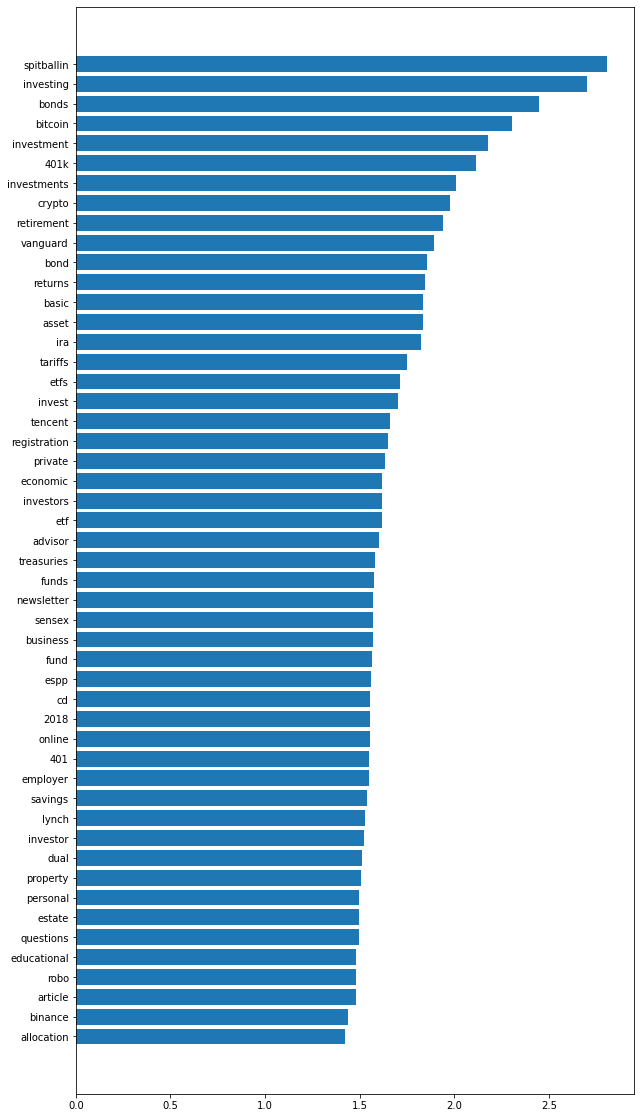

# 'stocks':
Feature: , Score:  (0, ('referral', 1.0855879778840207))
Feature: , Score:  (1, ('clsk', 1.088511446746685))
Feature: , Score:  (2, ('arkk', 1.0935045549542735))
Feature: , Score:  (3, ('insiders', 1.09661244661995))
Feature: , Score:  (4, ('2021', 1.0979626382843257))
Feature: , Score:  (5, ('wins', 1.0984391443523578))
Feature: , Score:  (6, ('fell', 1.106342615317925))
Feature: , Score:  (7, ('niu', 1.112129689773726))
Feature: , Score:  (8, ('https', 1.1122823217307607))
Feature: , Score:  (9, ('14', 1.1151732375711496))
Feature: , Score:  (10, ('nasdaq', 1.116846101949735))
Feature: , Score:  (11, ('plant', 1.123672522491402))
Feature: , Score:  (12, ('hyln', 1.1276976443618925))
Feature: , Score:  (13, ('bep', 1.1296990682437011))
Feature: , Score:  (14, ('sbe', 1.1366835229755163))
Feature: , Score:  (15, ('ttcf', 1.1381515106692381))
Feature: , Score:  (16, ('square', 1.1447676119321855))
Feature: , Score:  (17, ('particular', 1.1506788563962524))
Feature: , Score: 

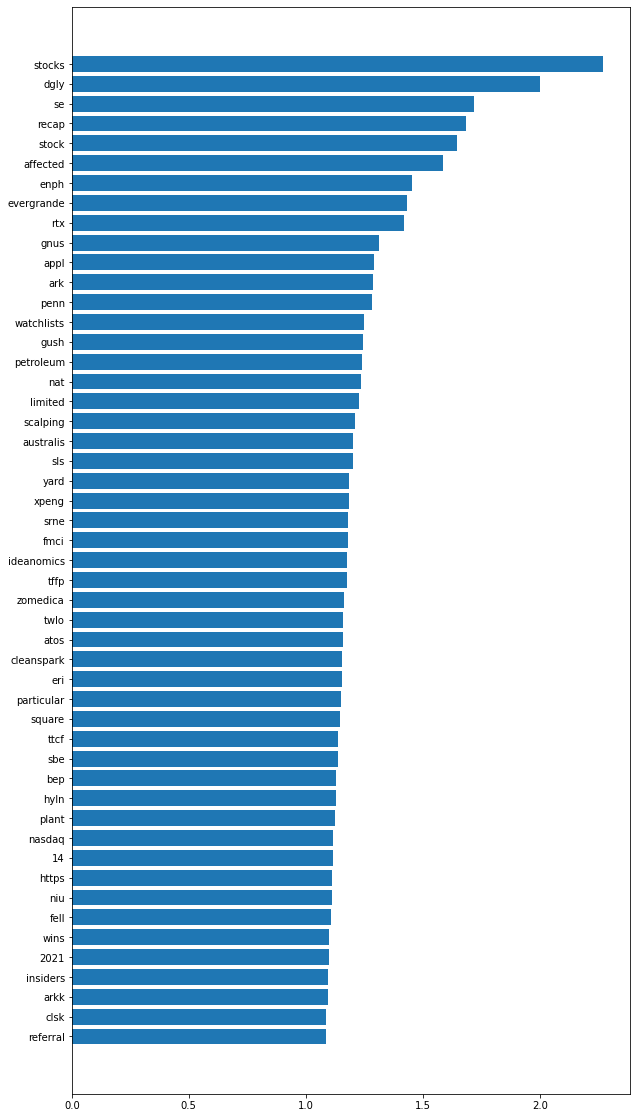

# 'wsb':
Feature: , Score:  (0, ('meme', 1.440287170927788))
Feature: , Score:  (1, ('nok', 1.4629344075118365))
Feature: , Score:  (2, ('irnt', 1.4737677111846141))
Feature: , Score:  (3, ('uwmc', 1.4846871520584193))
Feature: , Score:  (4, ('puts', 1.4944214345600162))
Feature: , Score:  (5, ('pltr', 1.512524472436705))
Feature: , Score:  (6, ('hands', 1.5172148606308804))
Feature: , Score:  (7, ('fucks', 1.5188982320066031))
Feature: , Score:  (8, ('mooning', 1.5408209000603135))
Feature: , Score:  (9, ('citadel', 1.5540648630723433))
Feature: , Score:  (10, ('imagine', 1.563233861180613))
Feature: , Score:  (11, ('clne', 1.5645722503833455))
Feature: , Score:  (12, ('robinhood', 1.5839825119718738))
Feature: , Score:  (13, ('yoloing', 1.6170954040761236))
Feature: , Score:  (14, ('boys', 1.6455647156767177))
Feature: , Score:  (15, ('moon', 1.6617597295327102))
Feature: , Score:  (16, ('literally', 1.6808938041655384))
Feature: , Score:  (17, ('petition', 1.7001312486898263))
Featu

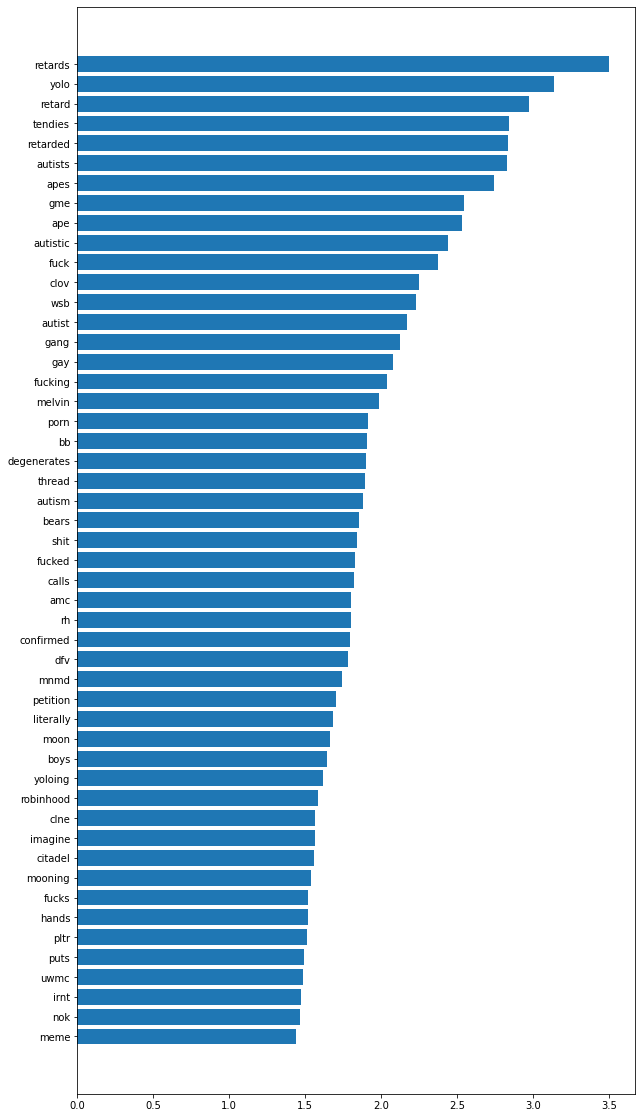

In [33]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[(len(feature_names[:])-50):],importance[(len(feature_names[:])-50):])):
        print('Feature: , Score: ',(i,v))
    # plot feature importance
    #pyplot.bar([x for x in range(len(importance[:10]))], importance[:10])
    pyplot.figure(figsize=(10,20))
    pyplot.barh(feature_names[len(feature_names[:])-50:], importance[len(feature_names[:])-50:])    
    pyplot.show()